# Figure 6: Chirp signal extraction pipeline.

In [1]:
from utils import *

color_map = sns.color_palette("cubehelix", 3).as_hex()

hatch_map = ['', '/', '//']

# Set seaborn style
sns.set_theme(style="whitegrid")

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['lines.linewidth'] = 5

fontsize = 16
matplotlib.rcParams['xtick.labelsize'] = fontsize
matplotlib.rcParams['ytick.labelsize'] = fontsize
matplotlib.rcParams['axes.labelsize'] = fontsize
matplotlib.rcParams['legend.fontsize'] = fontsize

In [2]:
filename = "./Data/fig6/9000-9500-150-100-0-3-5.csv" # !!!! THIS IS THE ONE USED TO GENERATE MUSIC BENCHMARKING

speed_ratio = 0.7453

data = np.array(parse_csv_file(filename))
timestamp = data[:, 0]
# timestamp -= timestamp[0]
amplitude = data[:, 1] * 1.0
amplitude -= np.mean(amplitude)
fs = len(timestamp) / (timestamp[-1] - timestamp[0]) # timestamps in 1us
antenna_spacing = 0.1 
print(f"Sampling frequency: {fs} Hz")

start_freq, stop_freq, cd_time, dwells, angle, _, _ = parse_bin_name(filename)
expected_period = (cd_time + dwells) * 1e-6

gt_freqs = default_theory_freq(filename)

Sampling frequency: 200100.4520341537 Hz


[  11   60  110  160  210  260  310  360  410  460  510  560  610  660
  710  760  810  860  910  960 1010 1060 1110 1160 1210 1260 1310 1360
 1410 1460 1510 1560 1610 1660 1710 1760 1810 1860 1910 1960]


Text(0, 0.5, 'Amplitude')

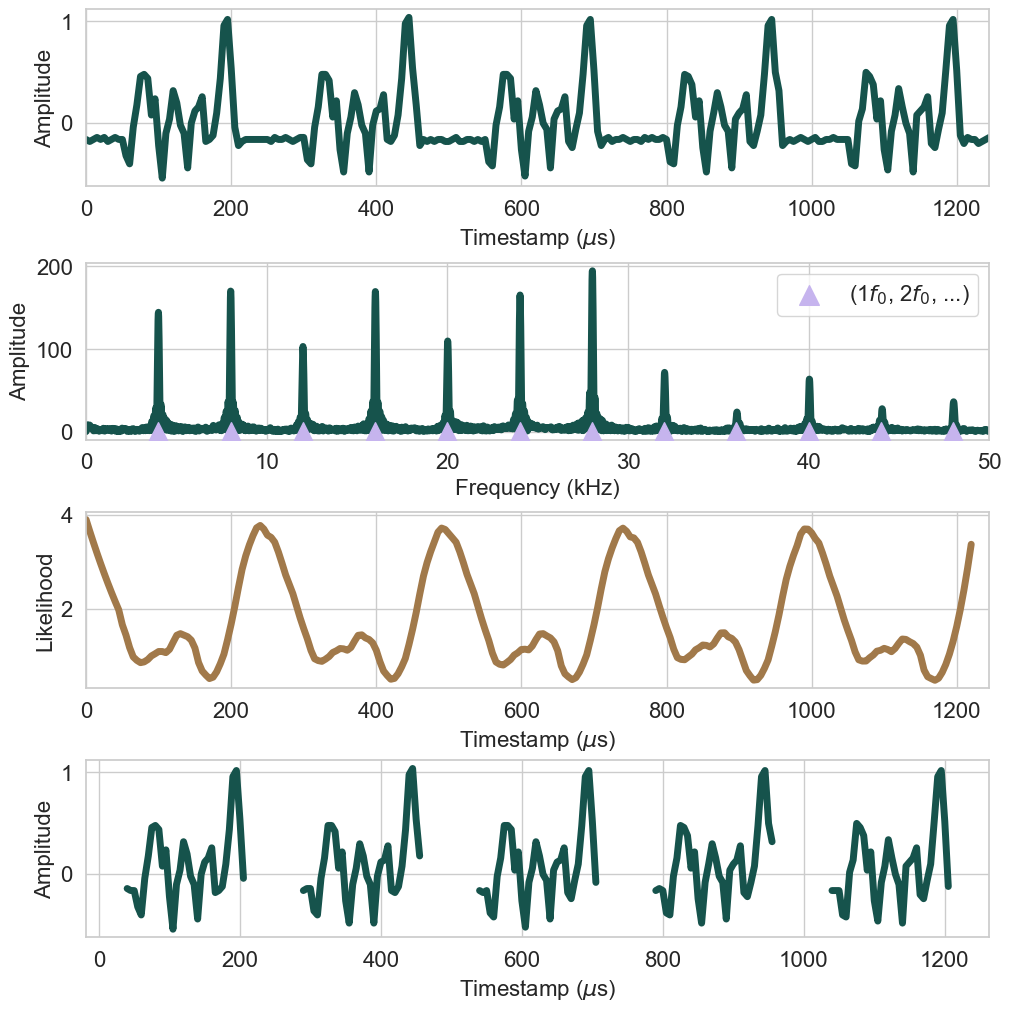

In [ ]:
plt.subplots(4, 1, constrained_layout=True, figsize=(10, 10))

# ! Figure A
segment_ind_start = 760
segment_ind_end = 1010

# Cut the signal
cutoff_timestamp = timestamp[segment_ind_start:segment_ind_end] * 1e6
cutoff_timestamp -= cutoff_timestamp[0]
cutoff_amplitude = amplitude[segment_ind_start:segment_ind_end]
l_time, r_time = 0, np.max(cutoff_timestamp)

plt.subplot(4, 1, 1)
plt.plot(cutoff_timestamp, cutoff_amplitude, color = color_map[0])
plt.xlabel("Timestamp ($\\mu$s)")
plt.xlim([l_time, r_time])
plt.ylabel("Amplitude")

# ! Figure B

from scipy.fft import rfft, rfftfreq

nfft = 2**14
fft_spectrum = rfft(amplitude, n = nfft)
frequencies = rfftfreq(nfft, 1 / fs) / 1e3
f_0 = 1 / (250e-6) / 1e3
f_0_list = f_0 * np.arange(1, int(50e3 / f_0))

plt.subplot(4, 1, 2)
plt.plot(frequencies, np.abs(fft_spectrum), color = color_map[0])
plt.scatter(f_0_list, np.zeros_like(f_0_list), label = f"(1$f_0$, 2$f_0$, ...)", color = color_map[2], zorder = 3, marker = '^', s = 200)
plt.xlim([0, 50])
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')
plt.legend()

# ! Figure C

segment_indices, corr = get_seg_idx_std(cutoff_amplitude, fs, window_length = 5)

plt.subplot(4, 1, 3)
plt.plot(cutoff_timestamp[:len(corr)], corr/ np.std(corr), color = color_map[1])
plt.xlabel('Timestamp ($\\mu$s)')
plt.xlim([l_time, r_time])
plt.ylabel('Likelihood')

# ! Figure D
# ? This is crop_signal() in utils with plotting functionality
def crop_signal_modified(timestamp, amplitude, fs, expected_period = None, num_segments = 3, num_skip_period = 0, crop_factor = 6,):
    segment_indices, _ = get_seg_idx_std(amplitude, fs, window_length = 5)
    print(segment_indices)

    segment_length = np.max(np.diff(segment_indices))
    crop_start_padding = int(segment_length // crop_factor)
    segment_length = segment_length - 2 * crop_start_padding
    num_segments = len(segment_indices) - 2 * num_skip_period - 1
    
    X = np.zeros((segment_length, num_segments))
    for idx in range(num_segments):
        offsetted_idx = idx + num_skip_period
        segment = amplitude[segment_indices[offsetted_idx] + crop_start_padding : segment_indices[offsetted_idx] + crop_start_padding + segment_length]
        X[:, idx] = segment - np.mean(segment)
        # X[:, idx] = segment - segment[0]
        l_index, r_index = segment_indices[offsetted_idx] + crop_start_padding, segment_indices[offsetted_idx] + crop_start_padding + segment_length
        if l_index > segment_ind_start and r_index < segment_ind_end:
            plt.plot(timestamp[l_index:r_index] * 1e6, segment, label = f"Segment {idx + 1}", color = color_map[0], linestyle = '-')
    return X, segment_indices

plt.subplot(4, 1, 4)
timestamp -= timestamp[segment_ind_start]
crop_signal_modified(timestamp, amplitude, fs, expected_period = 250e-3)
plt.xlabel('Timestamp ($\\mu$s)')
plt.ylabel('Amplitude')